### CIFAR-100 Dataset with Subset Selection

This notebook uses a **10-class subset** of CIFAR-100 for faster training and experimentation. The dataset is automatically filtered to include only the selected classes, and labels are remapped to 0-9.

**Available Subsets:**

- **`balanced`** (Balanced & Easy): Distinct shapes and colors - Recommended for quick training
  - Classes: beaver, shark, tulip, plate, television, chair, butterfly, bear, mountain, train
  - Class IDs: `[4, 73, 92, 61, 87, 20, 14, 3, 49, 90]`

- **`animals`** (All-Animals Theme): Consistent biological category
  - Classes: beaver, whale, trout, fox, wolf, chimpanzee, squirrel, raccoon, turtle, hamster
  - Class IDs: `[4, 95, 91, 34, 97, 21, 80, 66, 93, 36]`

- **`objects`** (Human-Made Objects): Object-focused subset
  - Classes: bottle, cup, keyboard, television, chair, table, house, road, pickup truck, train
  - Class IDs: `[9, 28, 39, 87, 20, 84, 37, 68, 58, 90]`

**To switch subsets:** Change `SUBSET_CHOICE = 'balanced'` in the next cell to `'animals'` or `'objects'`.


### Configuration Loading

Load all configuration settings from `config.json`, including training parameters and subset options.


In [9]:
import json
from pathlib import Path

# ============================================================================
# Load Configuration from JSON
# ============================================================================
config_path = Path('config.json')
if config_path.exists():
    with open(config_path, 'r') as f:
        config = json.load(f)
    print(f"Loaded configuration from {config_path}")


# Extract subset options from config
if 'subset_options' in config:
    subset_map = {name: opts['classes'] for name, opts in config['subset_options'].items()}
    SUBSET_CHOICE = config['subset_choice']
    selected_subset = subset_map[SUBSET_CHOICE]
else:
    # Fallback if subset_options not in config (for backward compatibility)
    print("Warning: subset_options not found in config.json. Using default subsets: balanced.")
    selected_subset = [4, 73, 92, 61, 87, 20, 14, 3, 49, 90]

baseline_model_dir = Path(config['model_dir']['baseline'])
baseline_reports_dir = Path(config['reports_dir']['baseline'])

print(f"\nConfiguration Summary:")
print(f"  Subset Choice: {SUBSET_CHOICE}")
if 'subset_options' in config and SUBSET_CHOICE in config['subset_options']:
    subset_info = config['subset_options'][SUBSET_CHOICE]
    print(f"  Subset Name: {subset_info['name']}")
    print(f"  Description: {subset_info['description']}")
    print(f"  Classes: {subset_info['classes']}")
    print(f"  Class Names: {subset_info['class_names']}")
print(f"  Learning Rate: {config['learning_rate']}")
print(f"  Epochs: {config['num_epochs']}")
print(f"  Batch Size: {config['batch_size']}")
print(f"  Baseline:")
print(f"    Model Directory: {baseline_model_dir}")
print(f"    Reports Directory: {baseline_reports_dir}")
if 'subset_options' in config and SUBSET_CHOICE in config['subset_options']:
    subset_info = config['subset_options'][SUBSET_CHOICE]
    print(f"    Model Name: {subset_info.get('model_name', 'None (will be auto-generated)')}")


Loaded configuration from config.json

Configuration Summary:
  Subset Choice: balanced
  Subset Name: Balanced & Easy
  Description: Distinct shapes and colors - Recommended for quick training
  Classes: [4, 73, 92, 61, 87, 20, 14, 3, 49, 90]
  Class Names: ['beaver', 'shark', 'tulip', 'plate', 'television', 'chair', 'butterfly', 'bear', 'mountain', 'train']
  Learning Rate: 0.001
  Epochs: 12
  Batch Size: 128
  Baseline:
    Model Directory: models/baseline
    Reports Directory: reports/baseline
    Model Name: 20251105_102247


### SubsetFilter Class

Custom PyTorch Dataset class that:
- Filters the dataset to only include samples from selected classes
- Remaps original class labels (0-99) to new labels (0-9) for the 10-class subset
- Maintains compatibility with PyTorch DataLoader


In [10]:
from torch.utils.data import Dataset

# ============================================================================
# Custom Dataset Filter Class
# ============================================================================
class SubsetFilter(Dataset):
    """Filter dataset to only include selected classes and remap labels to 0-9."""
    def __init__(self, dataset, selected_classes):
        self.dataset = dataset
        self.selected_classes = selected_classes
        # Create mapping from original class ID to new class ID (0-9)
        self.class_to_idx = {orig_class: new_idx for new_idx, orig_class in enumerate(selected_classes)}
        
        # Filter indices: only keep samples whose label is in selected_classes
        self.indices = []
        for idx, (_, label) in enumerate(dataset):
            if label in self.selected_classes:
                self.indices.append(idx)
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        image, original_label = self.dataset[actual_idx]
        # Remap label to 0-9
        new_label = self.class_to_idx[original_label]
        return image, new_label


### Loading and Preparing the Dataset

This section loads the CIFAR-100 dataset, applies the selected subset filter, and creates train/validation/test splits with DataLoaders.


In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(9527)

# Note: config, SUBSET_CHOICE, and selected_subset are already loaded from config.json in cell 4

# ============================================================================
# Load and Filter Dataset
# ============================================================================
# Read the CIFAR-100 dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the full training dataset (needed to access class names)
cifar100_full = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)

# Print subset information using the loaded dataset's classes
print(f"Using Subset {SUBSET_CHOICE} with classes: {selected_subset}")
print(f"Class names: {[cifar100_full.classes[i] for i in selected_subset]}")

# Filter to selected subset
cifar100_filtered = SubsetFilter(cifar100_full, selected_subset)

# Create 80/20 train-validation split with fixed random seed
train_size = int(0.8 * len(cifar100_filtered))
val_size = len(cifar100_filtered) - train_size
cifar100_train, cifar100_val = random_split(
    cifar100_filtered, 
    [train_size, val_size], 
    generator=torch.Generator().manual_seed(42)
)

# Load and filter test dataset
cifar100_test_full = datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)
cifar100_test = SubsetFilter(cifar100_test_full, selected_subset)

# Create DataLoaders with batch size 128
train_loader = DataLoader(cifar100_train, batch_size=128, shuffle=True)
val_loader = DataLoader(cifar100_val, batch_size=128)
test_loader = DataLoader(cifar100_test, batch_size=128)

# Print dataset sizes and class count
print(f"\nDataset Statistics:")
print(f"  Training set size: {len(cifar100_train)}")
print(f"  Validation set size: {len(cifar100_val)}")
print(f"  Test set size: {len(cifar100_test)}")
print(f"  Number of classes: {len(selected_subset)}")
print(f"  Selected classes: {selected_subset}")

# for idx, class_name in enumerate(cifar100_full.classes):
#     print(f"{idx}: {class_name}")



Files already downloaded and verified
Using Subset balanced with classes: [4, 73, 92, 61, 87, 20, 14, 3, 49, 90]
Class names: ['beaver', 'shark', 'tulip', 'plate', 'television', 'chair', 'butterfly', 'bear', 'mountain', 'train']
Files already downloaded and verified

Dataset Statistics:
  Training set size: 4000
  Validation set size: 1000
  Test set size: 1000
  Number of classes: 10
  Selected classes: [4, 73, 92, 61, 87, 20, 14, 3, 49, 90]


### Visualizing Training Images


Image shape: torch.Size([3, 32, 32])
Image shape matches (3, 32, 32): True
Target type: <class 'int'>
Target is integer: True
Target value example: 8


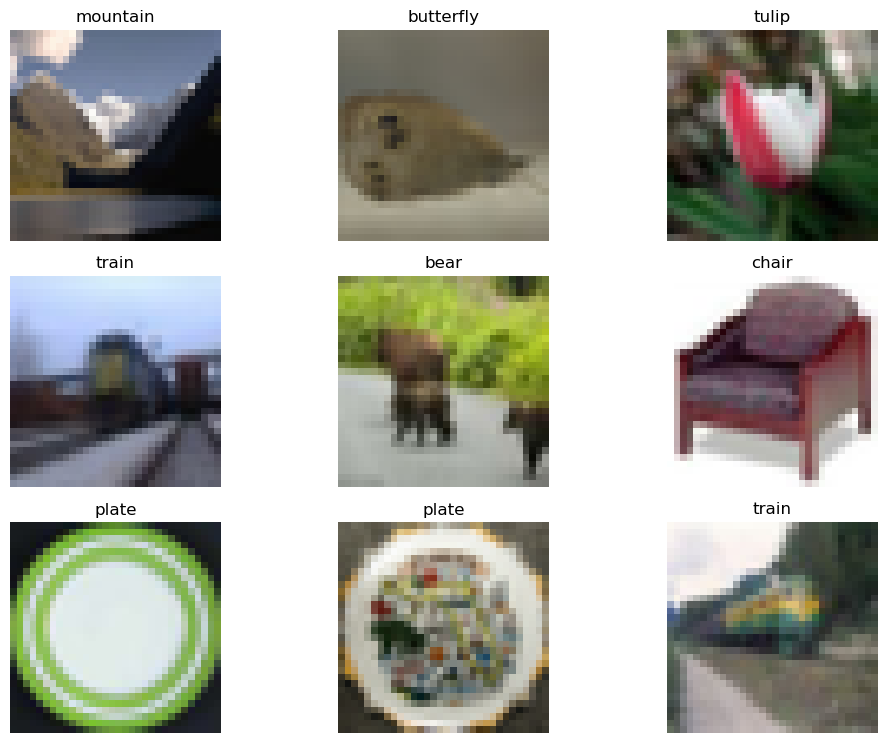

In [12]:
import matplotlib.pyplot as plt

# Get one batch from the training loader
images, labels = next(iter(train_loader))

# Confirm image shape and target type
print(f"Image shape: {images[0].shape}")
print(f"Image shape matches (3, 32, 32): {images[0].shape == (3, 32, 32)}")
print(f"Target type: {type(labels[0].item())}")
print(f"Target is integer: {isinstance(labels[0].item(), int)}")
print(f"Target value example: {labels[0].item()}")

# Plot 4×4 grid of images with class labels
plt.figure(figsize=(10, 10))
for index in range(9):
    plt.subplot(4, 3, index + 1)
    # Transpose from (C, H, W) to (H, W, C) for matplotlib
    img = images[index].numpy().transpose(1, 2, 0)
    # Get the class name for the label (remapped to 0-9, need to map back to original)
    remapped_label = labels[index].item()
    original_class_id = selected_subset[remapped_label]
    class_name = cifar100_full.classes[original_class_id]
    plt.imshow(img)
    plt.title(class_name, fontsize=12)
    plt.axis("off")
plt.tight_layout()
plt.show()


### Building the CNN Architecture


In [13]:
import torch.nn as nn

class BaseCnn(nn.Module):
    def __init__(self):
        super(BaseCnn, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv block 1
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Conv block 2
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),  # assuming input is 32x32 (CIFAR)
            nn.ReLU(),
            nn.Linear(128, config['num_classes'])  # 10 classes for subset
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

base_model = BaseCnn()
print(base_model)

# Print model summary and parameter count
total_params = sum(p.numel() for p in base_model.parameters())
trainable_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


BaseCnn(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

Total parameters: 545,098
Trainable parameters: 545,098


### Training Configuration


In [14]:
import os
import json
import numpy as np
import pandas as pd
from datetime import datetime
from pathlib import Path

# ============================================================================
# Training Configuration
# ============================================================================
# Note: config is already loaded from config.json in cell 4
# This cell just ensures directories exist and displays the configuration

# Create directories
os.makedirs(baseline_model_dir, exist_ok=True)
os.makedirs(baseline_reports_dir, exist_ok=True)

print("\nTraining Configuration:")
for key, value in config.items():
    if key != 'subset_options':  # Don't print the full subset_options dict
        print(f"  {key}: {value}")

if 'subset_options' in config and config['subset_choice'] in config['subset_options']:
    subset_info = config['subset_options'][config['subset_choice']]
    print(f"\n  Selected Subset Info:")
    print(f"    Name: {subset_info['name']}")
    print(f"    Description: {subset_info['description']}")
    print(f"    Classes: {subset_info['classes']}")
    print(f"    Class Names: {subset_info['class_names']}")



Training Configuration:
  learning_rate: 0.001
  num_epochs: 12
  batch_size: 128
  force_train: True
  model_dir: {'baseline': './models/baseline'}
  reports_dir: {'baseline': './reports/baseline'}
  subset_choice: balanced
  num_classes: 10

  Selected Subset Info:
    Name: Balanced & Easy
    Description: Distinct shapes and colors - Recommended for quick training
    Classes: [4, 73, 92, 61, 87, 20, 14, 3, 49, 90]
    Class Names: ['beaver', 'shark', 'tulip', 'plate', 'television', 'chair', 'butterfly', 'bear', 'mountain', 'train']


### Training Function (Unit)


In [21]:
def train_epoch(model, train_loader, loss_fn, optimizer, device):
    """Train for one epoch and return loss and accuracy."""
    # Make sure the model is past to the device
    model = model.to(device)
    
    model.train()
    train_loss = []
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        p = model(X_batch)
        loss = loss_fn(p, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
        # Calculate accuracy
        y_hat = p.argmax(1)
        correct += (y_hat == y_batch).sum().item()
        total += y_batch.shape[0]
    
    avg_loss = np.mean(train_loss)
    accuracy = correct / total
    return avg_loss, accuracy


def validate_epoch(model, val_loader, loss_fn, device):
    """Validate for one epoch and return loss and accuracy."""
    model.eval()
    val_loss = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            p = model(X_batch)
            loss = loss_fn(p, y_batch)
            
            val_loss.append(loss.item())
            
            # Calculate accuracy
            y_hat = p.argmax(1)
            correct += (y_hat == y_batch).sum().item()
            total += y_batch.shape[0]
    
    avg_loss = np.mean(val_loss)
    accuracy = correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, config, device):
    """Train the model and return training history."""
    # Setup loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    print(f"Starting training for {config['num_epochs']} epochs...")
    print("-" * 60)
    
    for epoch in range(config['num_epochs']):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, loss_fn, device)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        print(f"Epoch {epoch+1}/{config['num_epochs']}: "
              f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2%}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2%}")
    
    print("-" * 60)
    print("Training completed!")
    
    return history


### Train or Load Model


In [30]:

model_dir = baseline_model_dir
reports_dir = baseline_reports_dir

subset_name = config['subset_choice']
# Get model_name from the selected subset option
if 'subset_options' in config and subset_name in config['subset_options']:
    model_name = config['subset_options'][subset_name].get('model_name')  # Can be None
else:
    model_name = None

device = torch.device('cuda' if torch.cuda.is_available() 
                      else 'mps' if torch.backends.mps.is_available()
                      else 'cpu')

print(f"Currently using {device} to train...")

# Find existing models for this subset
existing_models = list(model_dir.glob(f'cnn_{subset_name}_*.pt'))
model_to_load = None
if not config['force_train']:
    # Priority 1: Load model by specific name if specified
    if model_name:
        named_model_path = model_dir / f'cnn_{subset_name}_{model_name}.pt'
        if named_model_path.exists():
            model_to_load = named_model_path
            print(f"Found model with specified name: {model_to_load}")
        else:
            print(f"Model with name '{model_name}' not found. Searching for latest model...")
    
    # Priority 2: Load latest model for this subset
    if model_to_load is None and existing_models:
        model_to_load = max(existing_models, key=os.path.getctime)
        print(f"Loading latest model for subset '{subset_name}': {model_to_load}")
    
    # Load the model if found
    if model_to_load:
        base_model.load_state_dict(torch.load(model_to_load, map_location=device))
        print("Model loaded successfully!")
        
        # Try to load training history if available
        history_file = baseline_reports_dir / f'train_log_{subset_name}.csv'
        if history_file.exists():
            print(f"Found training log at {history_file}")
            history_df = pd.read_csv(history_file)
            print(f"Training history has {len(history_df)} epochs")
        else:
            print("No training history found. Model loaded but history unavailable.")
            history_df = None
    else:
        print(f"No existing models found for subset '{subset_name}'. Will train a new model.")
        model_to_load = None

# ============================================================================
# Train New Model if Needed
# ============================================================================
if config['force_train'] or model_to_load is None:
    if model_to_load and config['force_train']:
        print(f"Force training enabled. Training new model despite existing model(s).")
    
    # Train the model
    history = train_model(base_model, train_loader, val_loader, config, device)
    
    # Save model
    subset_name = config['subset_choice']
    if model_name:
        # Use specified name if provided
        model_path = model_dir / f'cnn_{subset_name}_{model_name}.pt'
    else:
        # Use timestamp if no name specified
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = model_dir / f'cnn_{subset_name}_{timestamp}.pt'
    
    torch.save(base_model.state_dict(), model_path)
    print(f"Model saved to: {model_path}")
    
    # Save training history to CSV (subset-specific)
    history_df = pd.DataFrame(history)
    history_df['epoch'] = range(1, len(history_df) + 1)
    history_df = history_df[['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc']]

    log_path = reports_dir / f'train_log_{subset_name}.csv'
    # log_path = Path(config['reports_dir']['baseline']) / f'train_log_{subset_name}.csv'
    history_df.to_csv(log_path, index=False)
    print(f"Training log saved to: {log_path}")


Currently using mps to train...
Starting training for 12 epochs...
------------------------------------------------------------
Epoch 1/12: Train Loss = 0.0806, Train Acc = 97.82%, Val Loss = 1.7277, Val Acc = 72.70%
Epoch 2/12: Train Loss = 0.0041, Train Acc = 99.98%, Val Loss = 1.7710, Val Acc = 73.00%
Epoch 3/12: Train Loss = 0.0017, Train Acc = 100.00%, Val Loss = 1.8197, Val Acc = 72.50%
Epoch 4/12: Train Loss = 0.0012, Train Acc = 100.00%, Val Loss = 1.8544, Val Acc = 72.70%
Epoch 5/12: Train Loss = 0.0010, Train Acc = 100.00%, Val Loss = 1.8764, Val Acc = 72.40%
Epoch 6/12: Train Loss = 0.0009, Train Acc = 100.00%, Val Loss = 1.8938, Val Acc = 72.60%
Epoch 7/12: Train Loss = 0.0008, Train Acc = 100.00%, Val Loss = 1.9118, Val Acc = 72.90%
Epoch 8/12: Train Loss = 0.0008, Train Acc = 100.00%, Val Loss = 1.9317, Val Acc = 72.90%
Epoch 9/12: Train Loss = 0.0007, Train Acc = 100.00%, Val Loss = 1.9437, Val Acc = 73.00%
Epoch 10/12: Train Loss = 0.0007, Train Acc = 100.00%, Val Loss 

### Plotting Training Curves


Training curves saved to: reports/baseline/training_curves_balanced.png


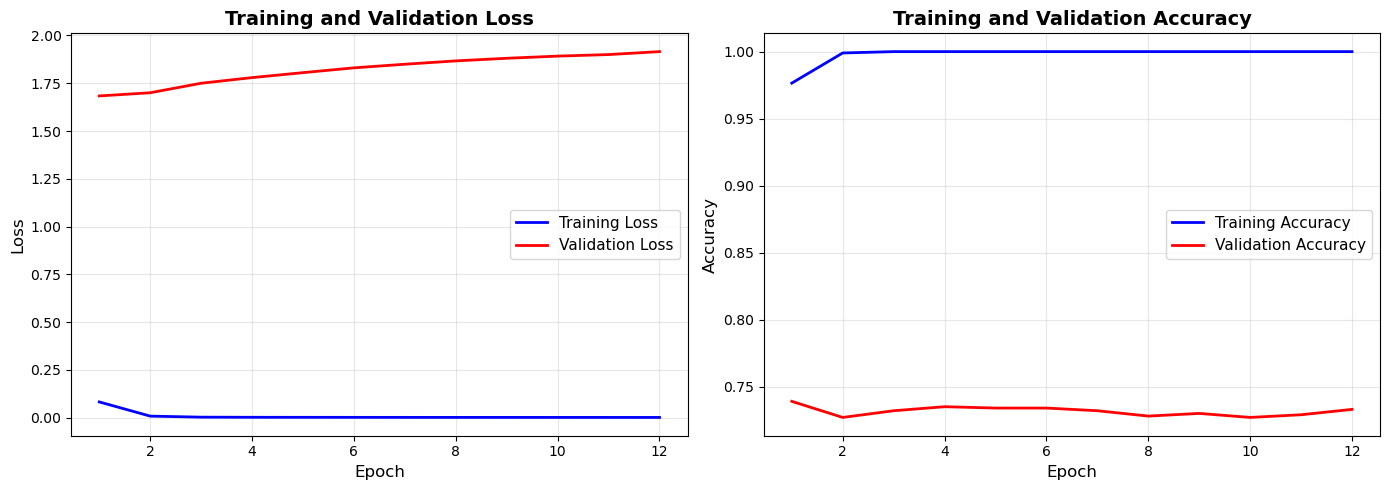


Training Summary:
  Final Train Loss: 0.0007
  Final Train Accuracy: 100.00%
  Final Val Loss: 1.9155
  Final Val Accuracy: 73.30%
  Best Val Accuracy: 73.90% (Epoch 1)


In [29]:
# Load history if not already loaded
if 'history_df' not in locals() or history_df is None:
    subset_name = config['subset_choice']
    history_file = baseline_reports_dir / f'train_log_{subset_name}.csv'
    if history_file.exists():
        history_df = pd.read_csv(history_file)
        print(f"Loaded training history from {history_file}")
    else:
        print(f"No training history available for plotting (looking for {history_file}).")
        history_df = None

if history_df is not None:
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = history_df['epoch'].values
    
    # Plot loss curves
    ax1.plot(epochs, history_df['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history_df['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy curves
    ax2.plot(epochs, history_df['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history_df['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot (subset-specific)
    subset_name = config['subset_choice']
    plot_path = baseline_reports_dir / f'training_curves_{subset_name}.png'
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"Training curves saved to: {plot_path}")
    
    plt.show()
    
    # Display summary statistics
    print("\nTraining Summary:")
    print(f"  Final Train Loss: {history_df['train_loss'].iloc[-1]:.4f}")
    print(f"  Final Train Accuracy: {history_df['train_acc'].iloc[-1]:.2%}")
    print(f"  Final Val Loss: {history_df['val_loss'].iloc[-1]:.4f}")
    print(f"  Final Val Accuracy: {history_df['val_acc'].iloc[-1]:.2%}")
    print(f"  Best Val Accuracy: {history_df['val_acc'].max():.2%} (Epoch {history_df.loc[history_df['val_acc'].idxmax(), 'epoch']})")
else:
    print("Cannot plot: No training history available.")
